# Allan Deviation of ROMY rings

### Import libraries

In [1]:
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import allantools

from andbro__get_data_archive import __get_data_archive
from andbro__querrySeismoData import __querrySeismoData

In [2]:

def __restitute(inv):

    pre_filter = (0.01, 0.05, 20, 40)

    out="VEL"  # "DISP" "ACC"

    st.remove_response(
        inventory=inv, 
        pre_filt=pre_filter,
        output=out,
    )
    print(f"response function removed! output = {out}")


### Load data online 

In [3]:
# seed_id = 'BW.ROMY.10.BJZ'
# seed_id = 'GR.FUR..BHZ'

# starttime  = obs.UTCDateTime("2018-05-14 00:00")
# endtime    = obs.UTCDateTime("2018-05-14 23:59")



## decide if response is removed or not
# __restitute(inv)

## --- online
# st, inv = __querrySeismoData(seed_id, starttime, endtime, True, None)

## --- archive
# st, inv = __get_data_archive(seed_id, starttime, endtime, raw=False)

### Load data local

In [4]:
## --- local 

net, sta, loc, cha = "BW.ROMY..FJV".split(".")

path = "/home/andbro/Documents/ROMY/monobeams/monobeam_data/"
file = 'DROMY_FJV_2021-02-05.mseed'
# inv  = '.xml'

st = obs.read(f"{path}{file}")

In [5]:
from obspy.clients.fdsn import RoutingClient

route = RoutingClient("eida-routing")

inv = route.get_stations(network="BW", station="ROMY", level="response")

st.remove_response(inv)


ValueError: No matching response information found.

### Data preparation

In [6]:
st.resample(1.0)

st.detrend('simple')
st.taper(0.05)

# st[0].data = [0].data/1e6

1 Trace(s) in Stream:
BW.DROMY..FJV | 2021-02-05T18:00:00.000000Z - 2021-02-05T18:59:59.000000Z | 1.0 Hz, 3600 samples

In [7]:
# global sta, cha, duration, period

def __get_parameters(st):
    
    global sta, cha, duration, period
    
    sta = st[0].stats.station
    cha = st[0].stats.channel
    
    duration = st[0].stats.npts*st[0].stats.delta
    
    if duration < 60: 
        period = f"{round(duration,0)} sec"
    elif duration >= 60 and duration < 3600:
        period = f"{int(duration/60)} min {round(duration%60,0)} sec"
    elif duration >= 3600:
        period = f"{int(duration/3600)}hr {round(duration%3600,0)}min {round(duration%60,0)}sec"
        
__get_parameters(st)

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (10.0) of bandpass is at or above Nyquist (0.5). Applying a high-pass instead.
  warnings.warn(msg)


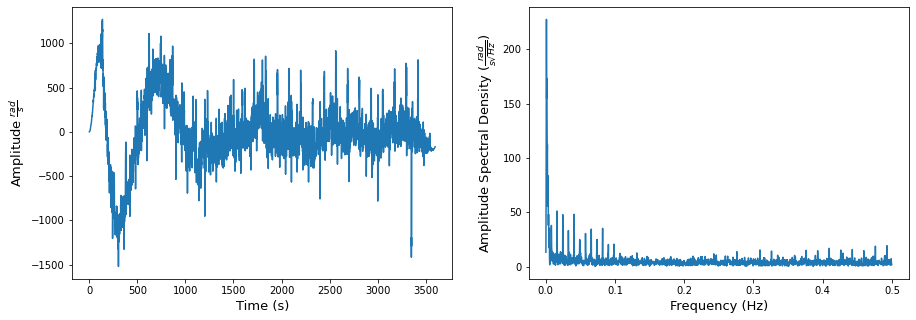

In [8]:
from andbro__makeplot_trace_spectrum import __makeplot_trace_and_spectrum

times = np.arange(0, st[0].data.size *st[0].stats.delta, st[0].stats.delta)

trace = st[0].copy()
# trace.detrend('simple')
# trace.taper(0.1)
trace.filter('bandpass', freqmin=0.001, freqmax=10.0)

__makeplot_trace_and_spectrum(trace.data, times);

### Calculation of Allan Deviation

In [9]:
## define tau range e.g. 5 (= 10⁵) and number of samples N
upper = 3
lower = 0
N = 2000

## list of tau values in seconds
taux = np.logspace(lower, upper, N)

## smallest sampling in seconds
dtaux = taux[1]-taux[0]


In [10]:

## normal allan deviation
(taus1, adevs1, errors, ns) = allantools.adev(st[0].data, 
                                              data_type="freq", 
                                              rate=st[0].stats.sampling_rate, 
                                              taus=taux,
                                             )

## overlapping allan deviations
(taus2, adevs2, errors, ns) = allantools.oadev(st[0].data, 
                                               data_type="freq", 
                                               rate=st[0].stats.sampling_rate, 
                                               taus=taux,
                                              )

## modified allan deviation
(taus3, adevs3, errors, ns) = allantools.mdev(st[0].data, 
                                              data_type="freq", 
                                              rate=st[0].stats.sampling_rate, 
                                              taus=taux,
                                             )

## allan deviation of white noise
# tau_white_noise = np.logspace(lower, 0, 30)  
# white_noise = allantools.noise.white(10000)  
# (tau_wn, ad_wn, ade, adn) = allantools.oadev(y, rate=r, data_type="freq", taus=t)  


### Plotting

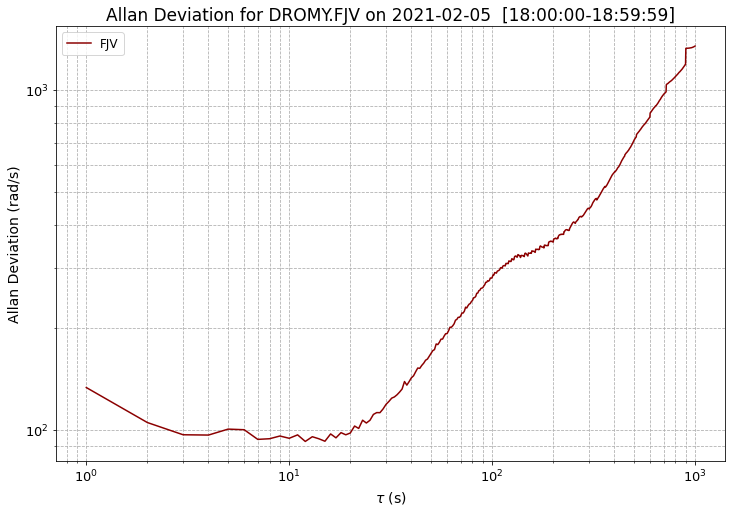

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

font = 14

# ax.scatter(taus1, adevs1, color='r')
ax.plot(taus1, adevs1, color='darkred', label=f"{cha}")

# ax.plot(tau_wn, ad_wn, color='grey', label="modified")


day = st[0].stats.starttime.date
tt1 = str(st[0].stats.starttime.time)[:8]
tt2 = str(st[0].stats.endtime.time)[:8]

ax.set_title(f"Allan Deviation for {sta}.{cha} on {day}  [{tt1}-{tt2}]", fontsize=font+3)
ax.set_xlabel(r"$\tau$ (s)", fontsize=font)
ax.set_ylabel("Allan Deviation (rad/s)", fontsize=font)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(fontsize=font-2)

ax.grid(True, which="both", ls="--")


# ax.set_yticks([1e-9, 1e-10])
ax.tick_params(labelsize=font-1)

plt.show();

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))

font = 14

# ax.scatter(taus1, adevs1, color='r')
ax.plot(taus1, adevs1, color='r', label="normal")

# ax.scatter(taus2, adevs2, color='b')
ax.plot(taus2, adevs2, color='b', label="overlapping")

# ax.scatter(taus3, adevs3, color='g')
ax.plot(taus3, adevs3, color='g', label="modified")

# ax.plot(tau_wn, ad_wn, color='grey', label="modified")


day = st[0].stats.starttime.date
tt1 = str(st[0].stats.starttime.time)[:8]
tt2 = str(st[0].stats.endtime.time)[:8]

ax.set_title(f"Allan Deviation for {sta}.{cha} on {day}  [{tt1}-{tt2}]", fontsize=font+3)
ax.set_xlabel(r"$\tau$ (s)", fontsize=font)
ax.set_ylabel("Allan Deviation (rad/s)", fontsize=font)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(fontsize=font-2)

ax.grid(True, which="both", ls="--")


ax.set_yticks([1e-8, 1e-9, 1e-10])
ax.tick_params(labelsize=font-1)

plt.show();